# 1.Tổng quan
Bài toán nhận dữ liệu đến từ các giao dịch thương mại điện tử trong thực tế của Vesta - một công ty cung cấp dịch vụ thanh toán hàng đầu và chứa một loạt các tính năng từ loại thiết bị đến tính năng của sản phẩm. Nhiệm vụ của cuộc thi này là xây dựng các mô hình học máy để dự đoán xác suất để một giao dịch trực tuyến là gian lận (isFraud).

## Mục tiêu
Xác định mục tiêu nghiệp vụ chính của việc tìm kiếm các giao dịch gian lận:

Dự đoán xác suất giao dịch gian lận
Không nên dự đoán các giao dịch gian lận là không gian lận và ngược lại. Vì vậy, cần chú ý cả precision và recall.
Xây dựng các mô hình dự đoán để giải quyết bài toán phân loại nhị phân -> giảm thiểu cả false negatives (FN) và false positives (FP).
Chú ý các giao dịch lớn, vì chúng có thể gây ra tổn thất lớn hơn nếu sai sót. Đặt ngưỡng xác suất thấp hơn -> chặt chẽ hơn để phân loại giao dịch gian lận khi liên quan đến số tiền giao dịch cao hơn.
Hiểu những yếu tố/ đặc trưng nào mang tính dự đoán cao hơn để phát hiện gian lận.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Thư viện

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

# Dữ liệu
Tập dữ liệu được chia thành 2 loại: 
* Transaction: 590540 hàng và 394 trường.
* Identity :  144233 hàng và 41 trường.

Các nhãn của tập Transaction bao gồm:
* ProductCD: Mã sản phẩm, sản phẩm cho mỗi giao dịch
* emaildomain: 
* card1 - card6: Thông tin thẻ thanh toán, chẳng hạn như loại thẻ, ngân hàng phát hành, quốc gia,..
* addr1, addr2: Địa chỉ
* P_emaildomain: Miền email người mua
* R_emaildomain: Miền email người nhận
* M1 - M9
Các nhãn của tập Identity bao gồm:
* DeviceType: Kiểu thiết bị
* DeviceInfo: Thông tin thiết bị
* id_12 - id_38

In [ ]:
train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [ ]:
print('Train_identity: ', train_id.shape)
print('Train_transaction: ', train_trans.shape)
print('Test_identity: ',test_id.shape)
print('Test_transaction: ', test_trans.shape)

In [ ]:
def check_value(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% Missing'})
        # mz_table['Total Zero & Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        # mz_table['% Total Zero & Missing Values'] = 100 * mz_table['Total Zero & Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table['Unique'] = df.nunique()
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% Missing', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

## Merge 2 tập Transaction và Identity
Do 2 loại dữ liệu đều chung trường Transaction ID, nên em quyết định sẽ merge 2 tập với nhau, dùng Transaction ID làm key dùng kiểu join right

In [ ]:
train = pd.merge(train_id,train_trans,left_on='TransactionID',right_on='TransactionID',how='right')
test = pd.merge(test_id,test_trans,left_on='TransactionID',right_on='TransactionID',how='right')
train.head()

Nhận xét: 
* Các trường dữ liệu trong tập train đang thiếu sót rất nhiều 
* Các giá trị của trường đang tồn tại lẫn cả Numerics và Categories

=> Giải quyết 2 vấn đề này bằng cách lấp đầy các trường dữ liệu thiếu, encode các nhãn

In [ ]:
del train_id, train_trans,test_id, test_trans
gc.collect()

### isFraud


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(6,4))

print(train['isFraud'].value_counts(dropna=False, normalize = True))

train['isFraud'].value_counts(dropna=False).plot(kind='bar', ax = ax)
ax.set_title('isFraud')

### TransactionDT
TransactionDT không phải là mốc thời gian thực tế

In [ ]:
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [ ]:
print('Giá trị thời gian lớn nhất của tập train:',train['TransactionDT'].max())
print('Giá trị thời gian nhỏ nhất của tập test:',test['TransactionDT'].min())

**Nhận xét:** 
* TransactionDT của tập test lớn hơn của tập train.

* Có nghĩa là TransactionDT của 2 tập không trùng nhau .

==> Có thể chia nhỏ tập train theo TransactionDT.

### TransactionAmt
TransactionAmt là số tiền thanh toán giao dịch bằng USD
Do có 1 số giao dịch làm lệch phân phối, vì thế ở đây em sử dụng logarit transform để biểu đạt rõ hơn sự phân phối 

In [ ]:
train['TransactionAmt'].apply(np.log).plot(
        kind='hist',
        bins=100,
        figsize=(15, 5),
        title='Distribution of Log Transaction Amt')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['TransactionAmt'].plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax1)
train.loc[train['isFraud'] == 0]['TransactionAmt'].plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax2)
plt.show()

In [ ]:
print('Giao dịch gian lận lớn nhất là {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].max()))
print('Giao dịch không gian lận lớn nhất là {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].max()))

Nhận xét:
* Các giao dịch nhỏ lẻ diễn ra nhất nhiều

## ProductCD
Đây là mã giao dịch cho mỗi lần giao dịch


In [ ]:
train.groupby('ProductCD')['TransactionID'].count().sort_index().plot(
    kind='barh',
    figsize=(15, 3),
    title='Số lượng các mã giao dịch')
plt.show()

Mã W chiếm phần lớn các giao dịch, mã C là thứ 2

In [ ]:
train.groupby('ProductCD')['isFraud'].mean().sort_index().plot(
    kind='barh',
    figsize=(15, 3),
    title='Percentage of Fraud by ProductCD')
plt.show()

Tuy nhiên các giao dịch mã W là ít gian lận nhất, trong khi đó giao dịch mã C chiếm phần trăm gian lận lớn nhất

## Card 1-6
Thông tin thẻ thanh toán, chẳng hạn như loại thẻ, kiểu thẻ, ngân hàng phát hành, quốc gia, v.v. 

In [ ]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

Có 4 nhãn số , 2 nhãn chữ là kiểu thẻ và loại thẻ

In [ ]:
color_idx = 0
for c in card_cols:
    if train[c].dtype in ['float64','int64']:
        train[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

In [ ]:
train_fr = train.loc[train['isFraud'] == 1]
train_non_fr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_non_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_non_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()


Thẻ debit là thẻ ghi nợ. Thẻ ghi nợ là thẻ thanh toán mà bạn chỉ có thẻ tiêu dùng giới hạn với số tiền bạn đang có trong tài khoản Ngân hàng đi kèm với thẻ đó

Thẻ credit là thẻ tín dụng. Thẻ tín dụng là loại thẻ cho phép bạn “vay tiền” của Ngân hàng để tạm thời mua sắm, khi tài khoản Ngân hàng của bạn đang không đủ tiền để chi tiêu.

==> Vì thế mặc dù số lượng thẻ credit ít hơn rất nhiều so với credit nhưng số lượng gian lận lại xấp xỉ nhau

## addr1 & addr2

In [ ]:
addr_cols = [c for c in train.columns if 'addr' in c]
train[addr_cols].head()

Mặc dù mô tả là địa chỉ nhưng giá trị của chúng lại là số

In [ ]:
train['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='Phân phối giá trị của addr1')
plt.show()
train['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='Phân phối giá trị của addr2')
plt.show()

Các giá trị của add1 được trải đều, tuy nhiên addr2 phần lớn giá trị là 87. 

## Dist1 & dist2 
Ở đây theo như host của cuộc thi thông báo chỉ là khoảng cách, tuy nhiên ta không biết đây là khoảng cách giữa cái gì với cái gì hoặc ai với ai

In [ ]:
train['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='Phân phối giá trị của dist1',
                                color=color_pal[1],
                                logx=True)
plt.show()
train['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='Phân phối giá trị của dist2',
                                color=color_pal[1],
                                logx=True)
plt.show()

## C1- C14
Dùng để đếm, chẳng hạn như có bao nhiêu địa chỉ được tìm thấy có liên quan đến thẻ thanh toán, v.v. Ví dụ như thiết bị, số lượng điện thoại, đỉa chỉ email,.. được liên kết đến người dùng 

In [ ]:
c_cols = [c for c in train if c[0] == 'C']
train[c_cols].head()

In [ ]:
check_value(train[c_cols])

In [ ]:
train[c_cols].nunique()

Không thiếu 1 giá trị nào trong các trường trên, bên cạnh đó số lượng giá trị khác biệt ở mỗi trường cũng rất lớn

## D1 - D15
Mô tả về hẹn giờ, ví dụ ngày trước giao dịch

In [ ]:
d_cols = [c for c in train if c[0] == 'D']
d_cols.remove('DeviceType')
d_cols.remove('DeviceInfo')
train[d_cols].head()

In [ ]:
check_value(train[d_cols])

Thiếu rất nhiều dữ liệu, ta sẽ phải xử lí vấn đề này 

## M1-M9


In [ ]:
m_cols = [c for c in train if c[0] == 'M']
train[m_cols].head()

Các giá trị trong cột này đều là T hoặc F, trừ có trường M4 là khác biệt

In [ ]:
(train[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Số lượng giá trị T mỗi cột',
                                              figsize=(15, 2),
                                              color=color_pal[3])
plt.show()
(train[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Số lượng giá trị F mỗi cột',
                                              figsize=(15, 2),
                                              color=color_pal[4])
plt.show()
(train[m_cols].isna()).sum().plot(kind='bar',
                                              title='Số lượng giá trị NaN mỗi cột',
                                              figsize=(15, 2),
                                              color=color_pal[0])
plt.show()

In [ ]:
train.groupby('M4')['TransactionID'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M4',
          figsize=(15, 3))
plt.show()

## V1- V339 
Vxxx: Vesta bao gồm xếp hạng, đếm và các quan hệ thực thể khác.

Ví dụ: số lần thẻ thanh toán được liên kết với IP và email hoặc địa chỉ xuất hiện trong phạm vi thời gian 24 giờ, v.v.
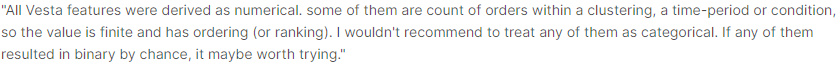

In [ ]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

In [ ]:
check_value(train[v_cols])

# Identity Table
Các giá trị trong bảng này là thông tin nhận dạng - thông tin kết nối mạng (IP, ISP, Proxy, v.v.) và chữ ký số (UA / browser / os / version, v.v.) được liên kết với các giao dịch.
Chúng được thu thập bởi hệ thống chống gian lận của Vesta và các đối tác bảo mật kỹ thuật số.
(Các tên trường được che dấu và từ điển ghép nối sẽ không được cung cấp để bảo vệ quyền riêng tư và thỏa thuận hợp đồng) 

## DeviceType

In [ ]:
train.groupby('DeviceType').mean()['isFraud'].sort_values().plot(
        kind='barh',
        figsize=(15, 5),
        title='Phần trăm gian lận theo kiểu thiết bị')
plt.show()

In [ ]:
train['DeviceType'].isnull().sum()

Thiếu nhiều như vậy là do merge 2 bảng, dữ liệu ban đầu chỉ thiếu 3423

## DeviceInfo
Các giá trị trong cột này đôi khi là kiểu máy, đôi khi là hệ điều hành. Tại vì dữ liệu trong cột này đến từ rất nhiều nguồn 
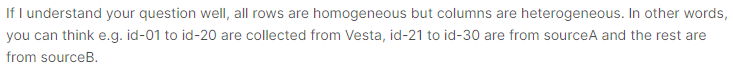

In [ ]:
train.groupby('DeviceInfo').count()['TransactionID'].sort_values(ascending=False).head(20).plot(
    kind='barh', 
    figsize=(15, 5), 
    title='Top 20 thiết bị sử dụng nhiều nhất')
plt.show()

In [ ]:
train['DeviceInfo'].isnull().sum()

Thiếu nhiều như vậy là do merge 2 bảng, dữ liệu ban đầu chỉ thiếu 25567

## ID 
id_01 đến id_11 là giá trị số cho danh tính, được Vesta và các đối tác bảo mật thu thập như xếp hạng thiết bị, xếp hạng ip_domain, xếp hạng proxy, v.v. Ngoài ra, nó còn ghi lại dấu vân tay hành vi như số lần đăng nhập tài khoản / lần đăng nhập không thành công, thời gian hoạt động trên trang, v.v. Tất cả những điều này đều không thể giải thích được do đối tác bảo mật T&C.

In [ ]:
id_nums = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11']
id_cate = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18','id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25','id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32','id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [ ]:
check_value(train[id_nums])

In [ ]:
check_value(train[id_cate])

Lượng dữ liệu trong các cột id đều thiếu rất nhiều, vì thế ta sẽ cần phải xử lý

**Nhận xét chung:**
* Tập dữ liệu thiếu sót rất nhiều
* Dữ liệu mất cân bằng khá nghiêm trọng
* Quá nhiều chiều dữ liệu, khó xử lí, có thể dẫn đến tràn RAM